In [5]:
# Starts the autoreload extension, which allows editing the .py files with the notebook running and automatically imports the latest changes

%load_ext autoreload
%autoreload 2

import trim_duplicates, model, network, gradcam, plots
from dataset import Dataset
import haiku as hk
import jax.numpy as jnp
import numpy as np
import jax
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import wandb
from sklearn.metrics import confusion_matrix

I0000 00:00:1654037495.861978  764431 tpu_initializer_helper.cc:116] libtpu.so is already in use by process with pid 762771. Not attempting to load libtpu.so in this process.
/home/joao/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
SEED = 14
DATASET = 'tawsifur'
NUM_CLASSES = 4

In [20]:
rng = jax.random.PRNGKey(SEED)

data = Dataset.load(DATASET, rng=rng, official_split = True)
rng = jax.random.split(rng)[0]

tcmalloc: large alloc 16644833280 bytes == 0x583bee000 @  0x7fe6b646a680 0x7fe6b648b824 0x7fe6aafc14ce 0x7fe6ab01700e 0x7fe6ab017c4f 0x7fe6ab0b9924 0x5f2fb9 0x5f3446 0x56fb02 0x56822a 0x5f6033 0x56b115 0x56822a 0x5f6033 0x56ef97 0x56822a 0x5f6033 0x56b115 0x56822a 0x68c1e7 0x5ff1f4 0x5c3cb0 0x569f5e 0x5002e8 0x56b95e 0x5002e8 0x56b95e 0x5002e8 0x503f46 0x56a136 0x5f5e56
tcmalloc: large alloc 16644833280 bytes == 0x964dae000 @  0x7fe6b646a680 0x7fe6b648b824 0x7fe6b648bb8a 0x7fe3e26d037c 0x7fe3de164520 0x7fe3de174228 0x7fe3de177aac 0x7fe3de0b4fb2 0x7fe3dde8cc88 0x7fe3dde74991 0x5f2fb9 0x5f3446 0x50aa8b 0x56ef97 0x56822a 0x5f6033 0x5f5869 0x664d7d 0x5f2c0e 0x56b7b0 0x56822a 0x5f6033 0x5f2b87 0x56b7b0 0x56822a 0x5f6033 0x5f5869 0x664d7d 0x5f2c0e 0x56b7b0 0x5f5e56
tcmalloc: large alloc 13315866624 bytes == 0x583bee000 @  0x7fe6b646a680 0x7fe6b648b824 0x7fe6b648bb8a 0x7fe3e26d037c 0x7fe3de164520 0x7fe3de174228 0x7fe3de177aac 0x7fe3de0b4fb2 0x7fe3dde8cc88 0x7fe3dde74991 0x5f2fb9 0x5f3446 0x50

In [21]:
import trim_duplicates
sims = trim_duplicates.compute_similarities(data, None, None, True)

Calculating embeddings...


tcmalloc: large alloc 16644833280 bytes == 0x964dae000 @  0x7fe6b646a680 0x7fe6b648b824 0x7fe6b648bb8a 0x7fe3e26d037c 0x7fe3de164520 0x7fe3de174228 0x7fe3de177aac 0x7fe3de0b4fb2 0x7fe3dde8cc88 0x7fe3dde74991 0x5f2fb9 0x5f3446 0x50aa8b 0x56ef97 0x56822a 0x5f6033 0x5f5869 0x664d7d 0x5f2c0e 0x56b7b0 0x56822a 0x5f6033 0x5f2b87 0x56b7b0 0x56822a 0x5f6033 0x5f5869 0x664d7d 0x5f2c0e 0x56b7b0 0x5f5e56


Computing cosine similarities...


<AxesSubplot:ylabel='Count'>

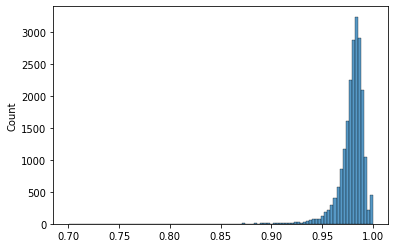

In [29]:
import seaborn as sns
max_sim = sims.max(0)
sns.histplot(max_sim, bins=100)

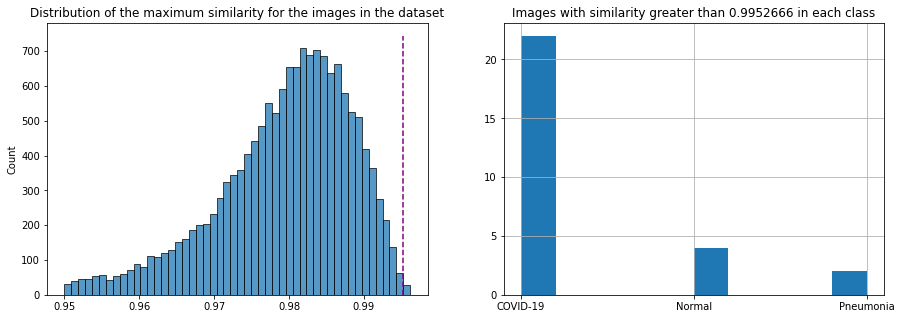

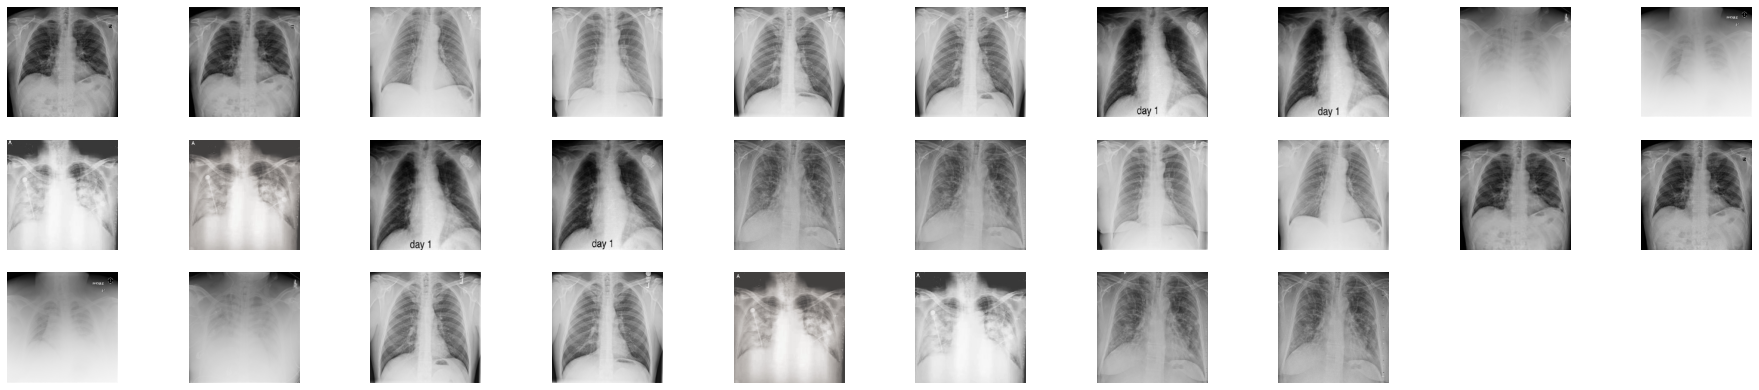

 36%|████████████████████████████████████████▎                                                                       | 5635/15634 [00:26<00:47, 211.38it/s]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/jax/_src/dtypes.py", line 339, in is_weakly_typed
    return x.aval.weak_type
AttributeError: 'int' object has no attribute 'aval'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/joao/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_2320302/2889939991.py", line 1, in <module>
    new_data = trim_duplicates.remove_duplicates(None, data, sims, None)
  File "/home/joao/disk/covid/trim_duplicates.py", line 120, in remove_duplicates
    one_duplicate = one_duplicate.union(set(list(np.nonzero(sims[i] > thresh)[0])))
  File "/usr/local/lib/python3.8/dist-packages/jax/_src/numpy/lax_numpy.py", line 4818, in _rewriting_take
    return _gather(arr, treedef, static_idx, dynamic_idx)
  File "/usr/local/lib/python3.8/dist-package

TypeError: object of type 'NoneType' has no len()

In [5]:
new_data = trim_duplicates.remove_duplicates(None, data, sims, None)

In [49]:
!mkdir data/covidx_curated

In [50]:
with open('data/covidx_curated/x_train.npy', 'wb') as f:
    np.save(f, new_data.x_train)
    
with open('data/covidx_curated/y_train.npy', 'wb') as f:
    np.save(f, new_data.y_train.argmax(1))
    
with open('data/covidx_curated/x_test.npy', 'wb') as f:
    np.save(f, new_data.x_test)
    
with open('data/covidx_curated/y_test.npy', 'wb') as f:
    np.save(f, new_data.y_test.argmax(1))